We are interested in understanding how stochastic vs. deterministic rounding affects quantized embeddings. This notebook contains some experiments (with both real and synthetic) datasets that attempt to shed some insight.

At present, I do not posit an "answer" but simply summarize out my current progress in understanding this phenomea. 

Table of Contents:

1) Synthetics

    1.1: vectors
    1.2: bitrate
    1.3: inner products
    1.5: clipping
    
    1.5: real data -- embeddings
    1.6: real data -- gramians
    1.7: clipping (TODO)

2) Empirical
    2.1: embeddings
    2.2: gramians
    2.3: 
    
    
Mathematical facts:
1) If implement correctly, stochastic rounding is unbiased for both embeddings and gramians (with the exception of the gramian's diagonal, for which the rounding is not independent).
2) For embeddings, deterministic rounding should always have <= Frobenius distortion compared to stochastic (holding everything else fixed)
3) If you have a distribution with support over interval [-L,L], and this distribution is symmetric around 0, then deterministic uniform rounding is also *unbiased* (both the distribution and the quantized distribution have mean 0).
4) The inner product <X,Y> is unbiased under stochastic rounding, assuming X and Y are quantized indepedently.

Empirical trends:
1) Word embeddings are, on the matirx level, "fairly" symmetric.


Key conclusions:
1) On glove embeddings, uniform quantization is unbiased regardless of bitrate, rounding scheme, or range.
2) On glove embeddings, uniform quantization has lower *gramian* Frobenius distortion in addition to embedding Frobenius distortion.



In [2]:
# import stuff
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.dirname(Path().resolve())) #FOR LOCAL IMPORTS
from maker.uniform_quant import stochround, naiveuni
from smallfry.utils import load_embeddings

*1.1: Vectors*

In [ ]:
#We begin by studying vectors generated synthetically.
#Below is a routine that makes vectors with correlation rho, each marginally iid uniform over [-1,1]
#Formula: (X_i,Y_i) = I_i*(W_i,W_i) + (1-I_i)(U_i,V_i) for W,U,V are iid uniform and I is iid bernoulli(rho)
def generate_uniform_correlated_vectors(rho=0,dim=100,L=1):
    W = np.random.random(3*dim)
    U1 = []
    U2 = []
    for i in range(dim):
        j = 3*i
        I = np.random.binomial(1,rho)
        U1.append(I*W[j] + (1-I)*W[j+1])
        U2.append(I*W[j] + (1-I)*W[j+2])
        
    U1 = (np.array(U1)*2 - 1)*L
    U2 = (np.array(U2)*2 - 1)*L
    return U1,U2

In [8]:
X,_ = generate_uniform_correlated_vectors(dim=1000) # sample iid uniform vector

#Let's compute the bias of a uniform quantization over the range [-1,1] for stochastic and deterministic rounding:

bias_determin = np.mean(X) - np.mean(naiveuni(X,1)) #binary
bias_stoch = np.mean(X) - np.mean(stochround(X,1)) #binary

print(f"bias determin : {bias_determin}")
print(f"bias_stoch : {bias_stoch}")

#Interestingly, neither the deterministic nor stochastic rounding seem to incur significant bias.
#This might seem surprising, but we should recall our distirbution is symmetric (mathematical fact 3)

-0.06406381266969123
0.015046632785025453


In [20]:
#What happens if we have a distribution that isn't symmetric?
def generate_normal_correlated_vectors(mu=0,rho=0,dim=100):
    N = np.random.multivariate_normal([mu,mu],[[1,rho],[rho,1]],dim)
    return N

In [32]:
X = generate_normal_correlated_vectors(dim=1000)[:,0] # sample iid Normal symmetric
Y = generate_normal_correlated_vectors(mu=1,dim=1000)[:,0] # sample iid Normal assymetric

bias_determin = np.mean(X) - np.mean(naiveuni(X,1)) #binary
bias_stoch = np.mean(X) - np.mean(stochround(X,1)) #binary

print(f"bias determin for sym : {bias_determin}")
print(f"bias_stoch for sym: {bias_stoch}")

bias_determin = np.mean(Y) - np.mean(naiveuni(Y,1)) #binary
bias_stoch = np.mean(Y) - np.mean(stochround(Y,1)) #binary

print(f"bias determin for assym : {bias_determin}")
print(f"bias_stoch for assym: {bias_stoch}")

bias determin for sym : -0.006639347318528142
bias_stoch for sym: 0.08828401481735901
bias determin for assym : -1.8210020544367695
bias_stoch for assym: 0.012412380949888169


Clearly, the deterministic quantization is biased when the distribution is assymmetric (note that in this particular case, the assymmetry is not fundmantal to the pdf, but is due to the protocol of centering the range at 0, producing a symmetric interval [-L,L] -- if the range would have been translated, we'd see the bias disappear since the Gaussian pdf is still symmetric about its mean). We note that the stochastic rounding is unbiased *despite* the zero-centered range.

*Takeaway: For distributions symmetric on the quantization range, determinstic rounding is unbiased*

*1.2: Bitrate*

TODO -- For now, I continue to focus on bitrate 1. I claim that at higher bitrates (say, 4+) both deterministic and stochastic rounding perform similarly. 


*1.3 Inner Product*

Any performance metric for embeddings should be rotation invariant -- the class of matrices up to rotation invariance uniquely determine a gramian (co-oc) matrix, so we can equivalently study the gramian associated with an embedding as the matrix for which performance depends.

Thus, we are concerned with how quantizing the embedding matrix induces distortion on the gramian matrix. 



In [53]:
'''
Utility function for loading in embeddings
'''

def load_glove_top10K(name):
    path = '/lfs/1/tginart/proj/smallfry/'
    if name == 'base':
        path = f"{path}base_embeddings/glove.6B.300d.txt.chopped_top_10000"
    elif name == 'clipped':
        path = f"{path}embeddings/2018-10-24-exp13-stoch-vs-det-round/base=glove,method=clipnoquant,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-24,rungroup=exp13-stoch-vs-det-round/base=glove,method=clipnoquant,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-24,rungroup=exp13-stoch-vs-det-round.txt"
    elif name == 'ada_stoch_round':
        path = f"{path}embeddings/2018-10-24-exp13-stoch-vs-det-round/base=glove,method=stochoptranuni,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-24,rungroup=exp13-stoch-vs-det-round/base=glove,method=stochoptranuni,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-24,rungroup=exp13-stoch-vs-det-round.txt"
    elif name == 'ada_det_round':
        path = f"{path}embeddings/2018-10-24-exp13-stoch-vs-det-round/base=glove,method=optranuni,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-24,rungroup=exp13-stoch-vs-det-round/base=glove,method=optranuni,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-24,rungroup=exp13-stoch-vs-det-round.txt"
    elif name == 'stoch_round':
        path = f"{path}embeddings/2018-10-26-exp13-stoch-vs-det-round/base=glove,method=stochround,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-26,rungroup=exp13-stoch-vs-det-round/base=glove,method=stochround,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-26,rungroup=exp13-stoch-vs-det-round.txt"
    elif name == 'det_round':
        path = f"{path}embeddings/2018-10-24-exp13-stoch-vs-det-round/base=glove,method=naiveuni,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-24,rungroup=exp13-stoch-vs-det-round/base=glove,method=naiveuni,vocab=10000,dim=300,ibr=1.0,seed=1234,date=2018-10-24,rungroup=exp13-stoch-vs-det-round.txt"
    return load_embeddings(path)[0]


In [13]:
'''
Compute gramian and various metrics of interest
'''
def eval_gramian(embeds, base_embeds):
    '''
    Takes in embeddings and computes various metrics of interest for gramian
    '''

    base_gram = gram = np.matmul(base_embeds,np.transpose(base_embeds))
    gram = np.matmul(embeds,np.transpose(embeds))

    res_rtn = dict()
    res_rtn['gramian-shape'] = gram.shape
    res_rtn['gramian-frob-dist'] = np.linalg.norm(base_gram - gram)
    res_rtn['gramian-bias'] = np.mean(base_gram) - np.mean(gram)
    res_rtn['gramian-frob-norm'] = np.linalg.norm(gram)
    sorted_gram = np.sort(gram.flatten())
    sorted_base_gram = np.sort(base_gram.flatten())

    def chunks(l, n):
        """Yield successive n-sized chunks from l."""
        for i in range(0, len(l), n):
            yield l[i:i + n]

    chunk_size = lambda x : int(np.ceil(len(x)/100))
    percentiles_gram = list(chunks(sorted_gram, chunk_size(sorted_gram)))
    percentiles_base_gram = list(chunks(sorted_base_gram, chunk_size(sorted_base_gram)))

    res_rtn['gramian-percentiles-len'] = [len(x) for x in percentiles_gram]
    res_rtn['gramian-percentiles-mean'] = [np.mean(x) for x in percentiles_gram]
    res_rtn['base-gramian-percentiles-mean'] = [np.mean(x) for x in percentiles_base_gram]
    res_rtn['gramian-percentiles-bias'] = list(np.array(res_rtn['gramian-percentiles-mean']) -
    np.array(res_rtn['base-gramian-percentiles-mean']))

    def compute_percentile_distortion(X,baseX):
        '''
        Takes in X = percentiles of gram and baseX = percentiles of base gram
        Computes percentile-wise metrics
        '''
        percentile_dist = []
        percentile_norms = []
        percentile_base_norms = []
        for i in range(len(X)):
            percentile_dist.append(np.linalg.norm(X[i] - baseX[i]))
            percentile_norms.append(np.linalg.norm(X[i]))
            percentile_base_norms.append(np.linalg.norm(baseX[i]))
        return percentile_dist, percentile_norms, percentile_base_norms

    dist, norms, base_norms = compute_percentile_distortion(percentiles_gram, percentiles_base_gram)
    res_rtn['gramian-percentiles-dist'] = dist
    res_rtn['gramian-percentiles-norms'] = norms
    res_rtn['base-gramian-percentiles-norms'] = base_norms
    res_rtn['gramian-percentiles-dist-ratios'] = list(np.array(dist)/np.array(base_norms))

    return res_rtn

In [54]:
X = load_glove_top10K('base')
X_c = load_glove_top10K('clipped')
X_q = load_glove_top10K('ada_det_round')
X_stoch = load_glove_top10K('ada_stoch_round')
X_naive_q = load_glove_top10K('det_round')
X_naive_stoch = load_glove_top10K('stoch_round')

In [74]:
gramian = lambda X : np.matmul(X,np.transpose(X))


print(np.mean(X) - np.mean(X_naive_q))
print(np.mean(X) - np.mean(X_naive_stoch))

print(np.mean(X - X_q))
print(np.mean(X - X_stoch))

print(np.mean(X_c - X_q))
print(np.mean(X_c - X_stoch))

print(np.mean((gramian(X_c) - gramian(X_q))**2))
print(np.mean((gramian(X_c) - gramian(X_stoch))**2))

8.635523216704057e-05
0.0018920136321670354
-0.0038346024344996215
-0.0036718261594996257
-9.763132425784693e-05
6.514495074215303e-05
0.9200754007442943
1.3945957506770443


In [102]:
z = np.argsort(gramian(X_q).flatten()) #takes a few seconds to run

g_sort = np.sort(gramian(X).flatten())

In [ ]:
import

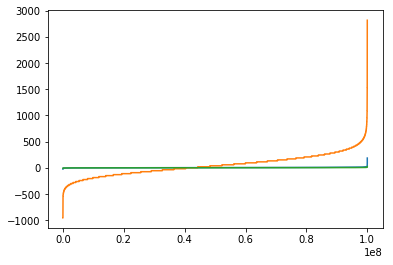

In [111]:
import matplotlib.pyplot as plt
plt.plot(g_sort)
plt.plot(gramian(X_naive_q).flatten()[z])
plt.plot(gramian(X_q).flatten()[z])
plt.show()

In [89]:
'''
Generate vectors synthetically
'''
def generate_uniform_correlated_vectors(p=0,dim=100,L=1):
    W = np.random.random(3*dim)
    U1 = []
    U2 = []
    for i in range(dim):
        j = 3*i
        I = np.random.binomial(1,p)
        U1.append(I*W[j] + (1-I)*W[j+1])
        U2.append(I*W[j] + (1-I)*W[j+2])
        
    U1 = (np.array(U1)*2 - 1)*L
    U2 = (np.array(U2)*2 - 1)*L
    return U1,U2

def generate_gaussian_embeddings():
    pass


In [91]:
'''
MAIN SCRIPT
'''
#make embeddings
base_embeds = generate_uniform_embeddings()
#quantize
naiveuni_embeds = naiveuni(base_embeds,1)
stochround_embeds = stochround(base_embeds,1)
results_naiveuni = eval_gramian(naiveuni_embeds, base_embeds)
results_stochround = eval_gramian(stochround_embeds, base_embeds)



[-43.998367 -43.998367 -43.998367 ...  99.99623   99.99623   99.99623 ]
[-49.99814 -49.99814 -45.99829 ...  99.99623  99.99623  99.99623]


In [92]:
results_stochround

{'base-gramian-percentiles-mean': [-8.881136496567219,
  -7.258285455636287,
  -6.553101222382616,
  -6.054284196837482,
  -5.658185710934228,
  -5.336498596994654,
  -5.057489670768843,
  -4.811287573620846,
  -4.585174208381691,
  -4.379676704602861,
  -4.18816071718721,
  -4.009128191581833,
  -3.841757660535344,
  -3.6824978457898103,
  -3.533485902567871,
  -3.387103841892133,
  -3.248380537256312,
  -3.115635114078621,
  -2.989095160837382,
  -2.8651835795956817,
  -2.744503295178363,
  -2.627352995642753,
  -2.513480990044671,
  -2.403412781482882,
  -2.294530422320781,
  -2.1893431645573984,
  -2.087098988963073,
  -1.986153700068586,
  -1.8878212026533672,
  -1.7908109339693565,
  -1.6966802159602425,
  -1.6022526199360596,
  -1.5089282715675931,
  -1.4158676944968136,
  -1.3228503945130317,
  -1.2337600087797749,
  -1.145887585043941,
  -1.0576991779265381,
  -0.9692737855904381,
  -0.8821186807294377,
  -0.7949894936777939,
  -0.7100398522670225,
  -0.6247495805757421,
  -0.

In [171]:
d = 100
X,Y = generate_uniform_correlated_vectors(p=0.8,dim=d)
print(np.matmul(X,np.transpose(Y))/np.sqrt(d))
print(np.matmul(naiveuni(X,1),np.transpose(naiveuni(Y,1))/np.sqrt(d)))
print(np.matmul(stochround(X,1),np.transpose(stochround(Y,1))/np.sqrt(d)))

2.9652273603786834
8.260973
2.7536573


In [156]:
X = np.random.random((100))*2-1
Xq = naiveuni(X,1)
Xq2 = stochround(X,1)

In [68]:
X

array([ 0.62817835, -0.59974819, -0.18839799,  0.78789062,  0.57070789,
        0.14425913, -0.49537752, -0.81472156,  0.27737307,  0.83736556,
        0.53364367,  0.392371  , -0.60483212,  0.60243901, -0.71972371,
        0.55712697,  0.8343099 , -0.41555817,  0.50759417,  0.74038843,
        0.18045926, -0.62081042,  0.06191311,  0.03596479,  0.94773984,
       -0.3140854 ,  0.21938727, -0.46186076,  0.90490518,  0.47443288,
       -0.75628688, -0.42472593,  0.06933557, -0.12440481,  0.49334255,
        0.45707695, -0.14646669,  0.10453331, -0.68124773,  0.43616414,
       -0.88724005, -0.36367109, -0.28259662, -0.23335512,  0.90582499,
       -0.17215739, -0.14222388, -0.8215975 ,  0.86114199, -0.90293997,
        0.70625998, -0.99686294, -0.74228296, -0.45730569, -0.42511162,
        0.81837818, -0.10908565,  0.79464902,  0.09877677, -0.14708972,
       -0.69922832,  0.25992809, -0.11908023,  0.57389203,  0.52707295,
       -0.35016612, -0.38583131, -0.73284269,  0.70446352,  0.90

In [69]:
np.matmul(np.transpose(X),X)

31.813847657006512

In [70]:
np.matmul(np.transpose(Xq),Xq)

99.50668

In [73]:
np.matmul(np.transpose(Xq2),stochround(X,1))

19.901339

In [76]:
np.random.binomial(1,0.8)


0